In [ ]:
# default_exp data.transforms

# Data Transforms

> Main functions used to transform TSTensors.

In [ ]:
#export
from fastai.vision.augment import RandTransform
from tsai.imports import *
from tsai.utils import *
from tsai.data.external import *
from tsai.data.core import *

In [ ]:
#export
from scipy.interpolate import CubicSpline
from scipy.ndimage import convolve1d, zoom
import pywt
from pyts.image.gaf import GramianAngularField

In [ ]:
dsid = 'NATOPS'
X, y, splits = get_UCR_data(dsid, parent_dir='./data/UCR/', verbose=True, on_disk=True, return_split=False)
tfms = [None, Categorize()]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
train_ds = dsets.train
valid_ds = dsets.valid

Dataset: NATOPS
X      : (360, 24, 51)
y      : (360,)
splits : ([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179], [180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 20

In [ ]:
#export
class ToNumpyCategory(Transform):
    "Categorize a numpy batch"
    order = 90

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def encodes(self, o: np.ndarray):
        self.type = type(o)
        self.cat = Categorize()
        self.cat.setup(o)
        self.vocab = self.cat.vocab
        return np.asarray(stack([self.cat(oi) for oi in o]))

    def decodes(self, o: (np.ndarray, torch.Tensor)):
        return stack([self.cat.decode(oi) for oi in o])

In [ ]:
t = ToNumpyCategory()
y_cat = t(y)
y_cat[:10]

array([3, 2, 2, 3, 2, 4, 0, 5, 2, 1])

In [ ]:
test_eq(t.decode(tensor(y_cat)), y)
test_eq(t.decode(np.array(y_cat)), y)

In [ ]:
#export
class OneHot(Transform): 
    "One-hot encode/ decode a batch"
    order = 90
    def __init__(self, n_classes=None, **kwargs): 
        self.n_classes = n_classes
        super().__init__(**kwargs)
    def encodes(self, o: torch.Tensor): 
        if not self.n_classes: self.n_classes = len(np.unique(o))
        return torch.eye(self.n_classes)[o]
    def encodes(self, o: np.ndarray): 
        o = ToNumpyCategory()(o)
        if not self.n_classes: self.n_classes = len(np.unique(o))
        return np.eye(self.n_classes)[o]
    def decodes(self, o: torch.Tensor): return torch.argmax(o, dim=-1)
    def decodes(self, o: np.ndarray): return np.argmax(o, axis=-1)

In [ ]:
oh_encoder = OneHot()
y_cat = ToNumpyCategory()(y)
oht = oh_encoder(y_cat)
oht[:10]

array([[0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]])

In [ ]:
n_classes = 10
n_samples = 100

t = torch.randint(0, n_classes, (n_samples,))
oh_encoder = OneHot()
oht = oh_encoder(t)
test_eq(oht.shape, (n_samples, n_classes))
test_eq(torch.argmax(oht, dim=-1), t)
test_eq(oh_encoder.decode(oht), t)

In [ ]:
n_classes = 10
n_samples = 100

a = np.random.randint(0, n_classes, (n_samples,))
oh_encoder = OneHot()
oha = oh_encoder(a)
test_eq(oha.shape, (n_samples, n_classes))
test_eq(np.argmax(oha, axis=-1), a)
test_eq(oh_encoder.decode(oha), a)

In [ ]:
#export
class TSStandardize(Transform):
    "Standardizes batch of type `NumpyTensor` or `TSTensor`"
    parameters, order = L('mean', 'std'), 97
    def __init__(self, mean=None, std=None, by_sample=False, by_var=False, verbose=False):
        self.mean = tensor(mean) if mean is not None else None
        self.std = tensor(std) if std is not None else None
        self.by_sample, self.by_var = by_sample, by_var
        if by_sample and by_var: self.axes = (2)
        elif by_sample: self.axes = (1, 2)
        elif by_var: self.axes = (0, 2)
        else: self.axes = ()
        self.verbose = verbose

    @classmethod
    def from_stats(cls, mean, std): return cls(mean, std)

    def setups(self, dl: DataLoader):
        if self.mean is None or self.std is None:
            x, *_ = dl.one_batch()
            self.mean, self.std = x.mean(self.axes, keepdim=self.axes!=()), x.std(self.axes, keepdim=self.axes!=()) + 1e-7
            if len(self.mean.shape) == 0: 
                pv(f'{self.__class__.__name__} setup mean={self.mean}, std={self.std}, by_sample={self.by_sample}, by_var={self.by_var}\n', 
                   self.verbose)
            else: 
                pv(f'{self.__class__.__name__} setup mean shape={self.mean.shape}, std shape={self.std.shape}, by_sample={self.by_sample}, by_var={self.by_var}\n', self.verbose)

    def encodes(self, x:(NumpyTensor, TSTensor)): 
        if self.by_sample: self.mean, self.std = x.mean(self.axes, keepdim=self.axes!=()), x.std(self.axes, keepdim=self.axes!=()) + 1e-7
        return (x - self.mean) / self.std

In [ ]:
#export
@patch
def mul_min(x:(torch.Tensor, TSTensor, NumpyTensor), axes=(), keepdim=False):
    if axes == (): return retain_type(x.min(), x)
    axes = reversed(sorted(axes if is_listy(axes) else [axes]))
    min_x = x
    for ax in axes: min_x, _ = min_x.min(ax, keepdim)
    return retain_type(min_x, x)


@patch
def mul_max(x:(torch.Tensor, TSTensor, NumpyTensor), axes=(), keepdim=False):
    if axes == (): return retain_type(x.max(), x)
    axes = reversed(sorted(axes if is_listy(axes) else [axes]))
    max_x = x
    for ax in axes: max_x, _ = max_x.max(ax, keepdim)
    return retain_type(max_x, x)


class TSNormalize(Transform):
    "Normalizes batch of type `NumpyTensor` or `TSTensor`"
    parameters, order = L('min', 'max'), 97

    def __init__(self, min=None, max=None, range=(-1, 1), by_sample=True, by_var=False, verbose=False):
        self.min = tensor(min) if min is not None else None
        self.max = tensor(max) if max is not None else None
        self.range_min, self.range_max = range
        self.by_sample, self.by_var = by_sample, by_var
        if by_sample and by_var: self.axes = (2)
        elif by_sample: self.axes = (1, 2)
        elif by_var: self.axes = (0, 2)
        else: self.axes = ()
        self.verbose = verbose
            
    @classmethod
    def from_stats(cls, min, max, range_min=0, range_max=1): return cls(min, max, self.range_min, self.range_max)

    def setups(self, dl: DataLoader):
        if self.min is None or self.max is None:
            x, *_ = dl.one_batch()
            self.min, self.max = x.mul_min(self.axes, keepdim=self.axes!=()), x.mul_max(self.axes, keepdim=self.axes!=())
            if len(self.min.shape) == 0: 
                pv(f'{self.__class__.__name__} setup min={self.min}, max={self.max}, range_min={self.range_min}, range_max={self.range_max}, by_sample={self.by_sample}, by_var={self.by_var}\n', self.verbose)
            else:
                pv(f'{self.__class__.__name__} setup min shape={self.min.shape}, max shape={self.max.shape}, range_min={self.range_min}, range_max={self.range_max}, by_sample={self.by_sample}, by_var={self.by_var}\n', self.verbose)

    def encodes(self, x:(NumpyTensor, TSTensor)): 
        if self.by_sample: self.min, self.max = x.mul_min(self.axes, keepdim=self.axes!=()), x.mul_max(self.axes, keepdim=self.axes!=())
        return torch.clamp(((x - self.min) / (self.max - self.min)) * (self.range_max - self.range_min) + self.range_min, 
                           self.range_min, self.range_max)

In [ ]:
batch_tfms=[TSStandardize(by_sample=True, by_var=False, verbose=True)]
dls = TSDataLoaders.from_dsets(train_ds, valid_ds, bs=128, num_workers=0, after_batch=batch_tfms)
xb, yb = next(iter(dls.train))
test_close(xb.mean(), 0, eps=1e-1)
test_close(xb.std(), 1, eps=1e-1)

TSStandardize setup mean shape=torch.Size([128, 1, 1]), std shape=torch.Size([128, 1, 1]), by_sample=True, by_var=False



In [ ]:
TSStandardize(by_sample=True, verbose=True)(xb)

TSTensor(samples:128, vars:24, len:51)

In [ ]:
batch_tfms=[TSStandardize(by_sample=True, by_var=False, verbose=False)]
dls = TSDataLoaders.from_dsets(train_ds, valid_ds, bs=128, num_workers=0, after_batch=batch_tfms)
xb, yb = next(iter(dls.train))
test_close(xb.mean(), 0, eps=1e-1)
test_close(xb.std(), 1, eps=1e-1)
xb, yb = next(iter(dls.valid))
test_close(xb.mean(), 0, eps=1e-1)
test_close(xb.std(), 1, eps=1e-1)

In [ ]:
batch_tfms=[TSNormalize(by_sample=True, by_var=False, verbose=False)]
dls = TSDataLoaders.from_dsets(train_ds, valid_ds, bs=128, num_workers=0, after_batch=batch_tfms)
xb, yb = next(iter(dls.train))
assert xb.max() <= 1
assert xb.min() >= -1
test_close(xb.min(), -1, eps=1e-1)
test_close(xb.max(), 1, eps=1e-1)
xb, yb = next(iter(dls.valid))
test_close(xb.min(), -1, eps=1e-1)
test_close(xb.max(), 1, eps=1e-1)

In [ ]:
dls = TSDataLoaders.from_dsets(train_ds, valid_ds, bs=128, num_workers=0)
xb, yb = next(iter(dls.train))

In [ ]:
#export
class TSStdBySample(Transform):
    "Standardizes each sample in a batch (optionally by_var)"
    order = 80
    def __init__(self, by_var=False):
        super().__init__()
        if by_var: self.dim = (2)
        else: self.dim = (1,2)
    
    def encodes(self, o: (NumpyTensor, TSTensor)):
        o /= o.std(self.dim, keepdim=True)
        o -= o.mean(self.dim, keepdim=True)
        return o

In [ ]:
test_close(TSStdBySample()(xb).std(), 1, eps=1e-2)

In [ ]:
#export
class TSIdentity(RandTransform):
    "Applies the identity tfm to a `TSTensor` batch"
    order = 90
    def __init__(self, magnitude=None, **kwargs): 
        self.magnitude = magnitude 
        super().__init__(**kwargs)
    def encodes(self, o: (NumpyTensor, TSTensor)): return o

In [ ]:
test_eq(TSIdentity()(xb, split_idx=0).shape, xb.shape)

In [ ]:
#export
# partial(TSShuffle_HLs, ex=0), 
class TSShuffle_HLs(RandTransform):
    "Randomly shuffles HIs/LOs of an OHLC `TSTensor` batch"
    order = 70
    def __init__(self, magnitude=1., ex=None, **kwargs): 
        self.magnitude, self.ex = magnitude, ex
        super().__init__(**kwargs)
    def encodes(self, o: (NumpyTensor, TSTensor)):
        if not self.magnitude or self.magnitude <= 0: return o
        timesteps = o.shape[-1] // 4
        pos_rand_list = np.random.choice(np.arange(timesteps),size=random.randint(1, timesteps),replace=False)
        rand_list = pos_rand_list * 4
        highs = rand_list + 1
        lows = highs + 1
        a = np.vstack([highs, lows]).flatten('F')
        b = np.vstack([lows, highs]).flatten('F')
        output = o.clone()
        output[...,a] = output[...,b]
        if self.ex is not None: output[...,self.ex,:] = o[...,self.ex,:]
        return output

In [ ]:
test_eq(TSShuffle_HLs()(xb, split_idx=0).shape, xb.shape)

In [ ]:
#export
# partial(TSShuffleSteps, ex=0), 
class TSShuffleSteps(RandTransform):
    "Randomly shuffles consecutive sequence datapoints in batch"
    order = 70
    def __init__(self, magnitude=1., ex=None, **kwargs): 
        self.magnitude, self.ex = magnitude, ex
        super().__init__(**kwargs)
    def encodes(self, o: (NumpyTensor, TSTensor)):
        if not self.magnitude or self.magnitude <= 0: return o
        odd = 1 - o.shape[-1]%2
        r = np.random.randint(2)
        timesteps = o.shape[-1] // 2
        pos_rand_list = np.random.choice(np.arange(0, timesteps - r * odd), size=random.randint(1, timesteps - r * odd),replace=False) * 2 + 1 + r
        a = np.vstack([pos_rand_list, pos_rand_list - 1]).flatten('F')
        b = np.vstack([pos_rand_list - 1, pos_rand_list]).flatten('F')
        output = o.clone()
        output[...,a] = output[...,b]
        if self.ex is not None: output[...,self.ex,:] = o[...,self.ex,:]
        return output

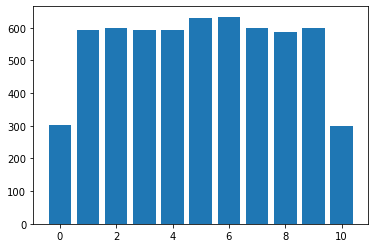

In [ ]:
t = TSTensor(torch.arange(11).float())
tt_ = []
for _ in range(1000): 
    tt = TSShuffleSteps()(t, split_idx=0)
    test_eq(len(set(tt.tolist())), len(t))
    test_ne(tt, t)
    tt_.extend([t for i,t in enumerate(tt) if t!=i])
x, y = np.unique(tt_, return_counts=True) # This is to visualize distribution which should be equal for all and half for first and last items
plt.bar(x, y);

In [ ]:
#export
class TSMagAddNoise(RandTransform):
    "Applies additive noise on the y-axis for each step of a `TSTensor` batch"
    order = 80
    def __init__(self, magnitude=1, ex=None, **kwargs):
        self.magnitude, self.ex = magnitude, ex
        super().__init__(**kwargs)
    def encodes(self, o: (NumpyTensor, TSTensor)):
        if not self.magnitude or self.magnitude <= 0: return o
        # output = o + torch.normal(0, o.std() * self.magnitude, o.shape, dtype=o.dtype, device=o.device)
        output = o + torch.normal(0, 1/3, o.shape, dtype=o.dtype, device=o.device) * (o[..., 1:] - o[..., :-1]).std(2, keepdims=True) * self.magnitude
        if self.ex is not None: output[...,self.ex,:] = o[...,self.ex,:]
        return output

class TSMagMulNoise(RandTransform): 
    "Applies multiplicative noise on the y-axis for each step of a `TSTensor` batch"
    order = 80
    def __init__(self, magnitude=1, ex=None, **kwargs): 
        self.magnitude, self.ex = magnitude, ex
        super().__init__(**kwargs)
    def encodes(self, o: (NumpyTensor, TSTensor)):
        if not self.magnitude or self.magnitude <= 0: return o
        noise = torch.normal(1, self.magnitude * .025, o.shape, dtype=o.dtype, device=o.device)
        output = o * noise
        if self.ex is not None: output[...,self.ex,:] = o[...,self.ex,:]
        return output

In [ ]:
test_eq(TSMagAddNoise()(xb, split_idx=0).shape, xb.shape)
test_eq(TSMagMulNoise()(xb, split_idx=0).shape, xb.shape)
test_ne(TSMagAddNoise()(xb, split_idx=0), xb)
test_ne(TSMagMulNoise()(xb, split_idx=0), xb)

In [ ]:
#export
def random_curve_generator(o, magnitude=0.1, order=4, noise=None):
    seq_len = o.shape[-1]
    f = CubicSpline(np.linspace(-seq_len, 2 * seq_len - 1, 3 * (order - 1) + 1, dtype=int), 
                    np.random.normal(loc=1.0, scale=magnitude, size=3 * (order - 1) + 1), axis=-1)
    return f(np.arange(seq_len))

def random_cum_curve_generator(o, magnitude=0.1, order=4, noise=None):
    x = random_curve_generator(o, magnitude=magnitude, order=order, noise=noise).cumsum()
    x -= x[0]
    x /= x[-1]
    x = np.clip(x, 0, 1)
    return x * (o.shape[-1] - 1)

def random_cum_noise_generator(o, magnitude=0.1, noise=None):
    seq_len = o.shape[-1]
    x = np.clip(np.ones(seq_len) + np.random.normal(loc=0, scale=magnitude, size=seq_len), 0, 1000).cumsum()
    x -= x[0]
    x /= x[-1]
    return x * (o.shape[-1] - 1)

def random_cum_linear_generator(o, magnitude=0.1):
    seq_len = o.shape[-1]
    win_len = int(round(seq_len * np.random.rand() * magnitude))
    if win_len == seq_len: return np.arange(o.shape[-1])
    start = np.random.randint(0, seq_len - win_len)
    # mult between .5 and 2
    rand = np.random.rand()
    mult = 1 + rand
    if np.random.randint(2): mult = 1 - rand/2
    x = np.ones(seq_len)
    x[start : start + win_len] = mult
    x = x.cumsum()
    x -= x[0]
    x /= x[-1]
    return np.clip(x, 0, 1) * (seq_len - 1)

In [ ]:
#export
class TSTimeNoise(RandTransform):
    "Applies noise to each step in the x-axis of a `TSTensor` batch based on smooth random curve"
    order = 80
    def __init__(self, magnitude=0.1, ex=None, **kwargs): 
        self.magnitude, self.ex = magnitude, ex
        super().__init__(**kwargs)
    def encodes(self, o: (NumpyTensor, TSTensor)):
        if not self.magnitude or self.magnitude <= 0: return o
        f = CubicSpline(np.arange(o.shape[-1]), o.cpu(), axis=-1)
        output = o.new(f(random_cum_noise_generator(o, magnitude=self.magnitude)))
        if self.ex is not None: output[...,self.ex,:] = o[...,self.ex,:]
        return output

In [ ]:
test_eq(TSTimeNoise()(xb, split_idx=0).shape, xb.shape)
test_ne(TSTimeNoise()(xb, split_idx=0), xb)

In [ ]:
#export
class TSMagWarp(RandTransform):
    "Applies warping to the y-axis of a `TSTensor` batch based on a smooth random curve"
    order = 80
    def __init__(self, magnitude=0.02, ord=4, ex=None, **kwargs): 
        self.magnitude, self.ord, self.ex = magnitude, ord, ex
        super().__init__(**kwargs)
    def encodes(self, o: (NumpyTensor, TSTensor)):
        if self.magnitude and self.magnitude <= 0: return o
        y_mult = random_curve_generator(o, magnitude=self.magnitude, order=self.ord)
        output = o * o.new(y_mult)
        if self.ex is not None: output[...,self.ex,:] = o[...,self.ex,:]
        return output

In [ ]:
test_eq(TSMagWarp()(xb, split_idx=0).shape, xb.shape)
test_ne(TSMagWarp()(xb, split_idx=0), xb)

In [ ]:
#export
class TSTimeWarp(RandTransform):
    "Applies time warping to the x-axis of a `TSTensor` batch based on a smooth random curve"
    order = 80
    def __init__(self, magnitude=0.02, ord=4, ex=None, **kwargs): 
        self.magnitude, self.ord, self.ex = magnitude, ord, ex
        super().__init__(**kwargs)
    def encodes(self, o: (NumpyTensor, TSTensor)):
        if not self.magnitude or self.magnitude <= 0: return o
        f = CubicSpline(np.arange(o.shape[-1]), o.cpu(), axis=-1)
        output = o.new(f(random_cum_curve_generator(o, magnitude=self.magnitude, order=self.ord)))
        if self.ex is not None: output[...,self.ex,:] = o[...,self.ex,:]
        return output

In [ ]:
test_eq(TSTimeWarp()(xb, split_idx=0).shape, xb.shape)
test_ne(TSTimeWarp()(xb, split_idx=0), xb)

In [ ]:
#export
class TSWindowWarp(RandTransform):
    """Applies window slicing to the x-axis of a `TSTensor` batch based on a random linear curve based on
    https://halshs.archives-ouvertes.fr/halshs-01357973/document"""
    order = 80
    def __init__(self, magnitude=0.1, ex=None, **kwargs): 
        self.magnitude, self.ex = magnitude, ex
        super().__init__(**kwargs)
    def encodes(self, o: (NumpyTensor, TSTensor)):
        if not self.magnitude or self.magnitude <= 0 or self.magnitude >= 1: return o
        f = CubicSpline(np.arange(o.shape[-1]), o.cpu(), axis=-1)
        output = o.new(f(random_cum_linear_generator(o, magnitude=self.magnitude)))
        if self.ex is not None: output[...,self.ex,:] = o[...,self.ex,:]
        return output

In [ ]:
test_eq(TSWindowWarp()(xb, split_idx=0).shape, xb.shape)
test_ne(TSWindowWarp()(xb, split_idx=0), xb)

In [ ]:
#export
class TSMagScale(RandTransform):
    "Applies scaling to the y-axis of a `TSTensor` batch based on a scalar"
    order = 80
    def __init__(self, magnitude=0.5, ex=None, **kwargs): 
        self.magnitude, self.ex = magnitude, ex
        super().__init__(**kwargs)
    def encodes(self, o: (NumpyTensor, TSTensor)):
        if not self.magnitude or self.magnitude <= 0: return o
        rand = random_half_normal()
        scale = (1 - (rand  * self.magnitude)/2) if random.random() > 1/3 else (1 + (rand  * self.magnitude))
        output = o * scale
        if self.ex is not None: output[...,self.ex,:] = o[...,self.ex,:]
        return output
    
class TSMagScalePerVar(RandTransform):
    "Applies per_var scaling to the y-axis of a `TSTensor` batch based on a scalar"
    order = 80
    def __init__(self, magnitude=0.5, ex=None, **kwargs): 
        self.magnitude, self.ex = magnitude, ex
        super().__init__(**kwargs)
    def encodes(self, o: (NumpyTensor, TSTensor)):
        if not self.magnitude or self.magnitude <= 0: return o
        s = [1] * o.ndim
        s[-2] = o.shape[-2]
        rand = random_half_normal_tensor(s, device=o.device)
        scale = (1 - (rand  * self.magnitude)/2) if random.random() > 1/3 else (1 + (rand  * self.magnitude))
        output = o * scale
        if self.ex is not None: output[...,self.ex,:] = o[...,self.ex,:]
        return output

In [ ]:
test_eq(TSMagScale()(xb, split_idx=0).shape, xb.shape)
test_eq(TSMagScalePerVar()(xb, split_idx=0).shape, xb.shape)
test_ne(TSMagScale()(xb, split_idx=0), xb)
test_ne(TSMagScalePerVar()(xb, split_idx=0), xb)

In [ ]:
#export
class TSRandomResizedCrop(RandTransform):
    "Randomly amplifies a sequence focusing on a random section of the steps"
    order = 95
    def __init__(self, magnitude=0.1, ex=None, mode='linear', **kwargs): 
        "mode:  'nearest' | 'linear' | 'area'"
        self.magnitude, self.ex, self.mode = magnitude, ex, mode
        super().__init__(**kwargs)
    def encodes(self, o: (NumpyTensor, TSTensor)):
        if not self.magnitude or self.magnitude <= 0: return o
        seq_len = o.shape[-1]
        lambd = np.random.beta(self.magnitude, self.magnitude)
        lambd = max(lambd, 1 - lambd)
        win_len = int(round(seq_len * lambd))
        if win_len == seq_len: return o
        start = np.random.randint(0, seq_len - win_len)
        return F.interpolate(o[..., start : start + win_len], size=seq_len, mode=self.mode, align_corners=None if self.mode in ['nearest', 'area'] else False)
    
TSRandomZoomIn = TSRandomResizedCrop

In [ ]:
test_eq(TSRandomZoomIn(.5)(xb, split_idx=0).shape, xb.shape)

In [ ]:
#export
class TSWindowSlicing(RandTransform):
    "Randomly extracts an resize a ts slice based on https://halshs.archives-ouvertes.fr/halshs-01357973/document"
    order = 95
    def __init__(self, magnitude=0.1, ex=None, mode='linear', **kwargs): 
        "mode:  'nearest' | 'linear' | 'area'"
        self.magnitude, self.ex, self.mode = magnitude, ex, mode
        super().__init__(**kwargs)
    def encodes(self, o: (NumpyTensor, TSTensor)):
        if not self.magnitude or self.magnitude <= 0 or self.magnitude >= 1: return o
        seq_len = o.shape[-1]
        win_len = int(round(seq_len * (1 - self.magnitude)))
        if win_len == seq_len: return o
        start = np.random.randint(0, seq_len - win_len)
        return F.interpolate(o[..., start : start + win_len], size=seq_len, mode=self.mode, align_corners=None if self.mode in ['nearest', 'area'] else False)

In [ ]:
test_eq(TSWindowSlicing()(xb, split_idx=0).shape, xb.shape)
test_ne(TSWindowSlicing()(xb, split_idx=0), xb)

In [ ]:
#export
class TSRandomZoomOut(RandTransform):
    "Randomly compresses a sequence on the x-axis"
    order = 95
    def __init__(self, magnitude=0.1, ex=None, mode='linear', **kwargs): 
        "mode:  'nearest' | 'linear' | 'area'"
        self.magnitude, self.ex, self.mode = magnitude, ex, mode
        super().__init__(**kwargs)
    def encodes(self, o: (NumpyTensor, TSTensor)):
        if not self.magnitude or self.magnitude <= 0: return o
        seq_len = o.shape[-1]
        lambd = np.random.beta(self.magnitude, self.magnitude)
        lambd = max(lambd, 1 - lambd)
        win_len = int(round(seq_len * lambd))
        if win_len == seq_len: return o
        start = (seq_len - win_len) // 2
        output = torch.zeros_like(o, dtype=o.dtype, device=o.device)
        interp = F.interpolate(o, size=win_len, mode=self.mode, align_corners=None if self.mode in ['nearest', 'area'] else False)
        output[..., start:start + win_len] = o.new(interp)
        return output

In [ ]:
test_eq(TSRandomZoomOut(.5)(xb, split_idx=0).shape, xb.shape)

In [ ]:
#export
class TSRandomTimeScale(RandTransform):
    "Randomly amplifies/ compresses a sequence on the x-axis keeping the same length"
    order = 95
    def __init__(self, magnitude=0.1, ex=None, mode='linear', **kwargs): 
        "mode:  'nearest' | 'linear' | 'area'"
        self.magnitude, self.ex, self.mode = magnitude, ex, mode
        super().__init__(**kwargs)
    def encodes(self, o: (NumpyTensor, TSTensor)):
        if not self.magnitude or self.magnitude <= 0: return o
        if np.random.rand() <= 0.5: return TSRandomZoomIn(magnitude=self.magnitude, ex=self.ex, mode=self.mode)(o, split_idx=0)
        else: return TSRandomZoomOut(magnitude=self.magnitude, ex=self.ex, mode=self.mode)(o, split_idx=0)

In [ ]:
test_eq(TSRandomTimeScale(.5)(xb, split_idx=0).shape, xb.shape)

In [ ]:
#export
class TSRandomTimeStep(RandTransform):
    "Compresses a sequence on the x-axis by randomly selecting sequence steps and interpolating to previous size"
    order = 95
    def __init__(self, magnitude=0.02, ex=None, mode='linear', **kwargs): 
        "mode:  'nearest' | 'linear' | 'area'"
        self.magnitude, self.ex, self.mode = magnitude, ex, mode
        super().__init__(**kwargs)
    def encodes(self, o: (NumpyTensor, TSTensor)):
        if not self.magnitude or self.magnitude <= 0: return o
        seq_len = o.shape[-1]
        new_seq_len = int(round(seq_len * max(.5, (1 - np.random.rand() * self.magnitude))))
        if  new_seq_len == seq_len: return o
        timesteps = np.sort(np.random.choice(np.arange(seq_len),new_seq_len, replace=False))
        output = F.interpolate(o[..., timesteps], size=seq_len, mode=self.mode, align_corners=None if self.mode in ['nearest', 'area'] else False)
        if self.ex is not None: output[...,self.ex,:] = o[...,self.ex,:]
        return output

In [ ]:
test_eq(TSRandomTimeStep()(xb, split_idx=0).shape, xb.shape)

In [ ]:
#export
class TSBlur(RandTransform):
    "Blurs a sequence applying a filter of type [1, 0, 1]"
    order = 80
    def __init__(self, magnitude=1., ex=None, **kwargs): 
        self.magnitude, self.ex = magnitude, ex
        self.filterargs = np.array([1, 0, 1])
        super().__init__(**kwargs)
    def encodes(self, o: (NumpyTensor, TSTensor)):
        if not self.magnitude or self.magnitude <= 0: return o
        w = self.filterargs * np.random.rand(3)
        w = w / w.sum()
        output = o.new(convolve1d(o.cpu(), w, mode='nearest'))
        if self.ex is not None: output[...,self.ex,:] = o[...,self.ex,:]
        return output

In [ ]:
test_eq(TSBlur()(xb, split_idx=0).shape, xb.shape)
test_ne(TSBlur()(xb, split_idx=0), xb)

In [ ]:
#export
class TSSmooth(RandTransform):
    "Smoothens a sequence applying a filter of type [1, 5, 1]"
    order = 80
    def __init__(self, magnitude=1., ex=None, **kwargs): 
        self.magnitude, self.ex = magnitude, ex
        self.filterargs = np.array([1, 5, 1])
        super().__init__(**kwargs)
    def encodes(self, o: (NumpyTensor, TSTensor)):
        if not self.magnitude or self.magnitude <= 0: return o
        w = self.filterargs * np.random.rand(3)
        w = w / w.sum()
        output = o.new(convolve1d(o.cpu(), w, mode='nearest'))
        if self.ex is not None: output[...,self.ex,:] = o[...,self.ex,:]
        return output

In [ ]:
test_eq(TSSmooth()(xb, split_idx=0).shape, xb.shape)
test_ne(TSSmooth()(xb, split_idx=0), xb)

In [ ]:
#export
def maddest(d, axis=None): #Mean Absolute Deviation
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

class TSFreqDenoise(RandTransform):
    "Denoises a sequence applying a wavelet decomposition method"
    order = 80
    def __init__(self, magnitude=0.1, ex=None, wavelet='db4', level=2, thr=None, thr_mode='hard', pad_mode='per', **kwargs): 
        self.magnitude, self.ex = magnitude, ex
        self.wavelet, self.level, self.thr, self.thr_mode, self.pad_mode = wavelet, level, thr, thr_mode, pad_mode
        super().__init__(**kwargs)
    def encodes(self, o: (NumpyTensor, TSTensor)):
        if not self.magnitude or self.magnitude <= 0: return o
        """
        1. Adapted from waveletSmooth function found here:
        http://connor-johnson.com/2016/01/24/using-pywavelets-to-remove-high-frequency-noise/
        2. Threshold equation and using hard mode in threshold as mentioned
        in section '3.2 denoising based on optimized singular values' from paper by Tomas Vantuch:
        http://dspace.vsb.cz/bitstream/handle/10084/133114/VAN431_FEI_P1807_1801V001_2018.pdf
        """
        seq_len = o.shape[-1]
        # Decompose to get the wavelet coefficients
        coeff = pywt.wavedec(o.cpu(), self.wavelet, mode=self.pad_mode)
        # Calculate sigma for threshold as defined in http://dspace.vsb.cz/bitstream/handle/10084/133114/VAN431_FEI_P1807_1801V001_2018.pdf
        # As noted by @harshit92 MAD referred to in the paper is Mean Absolute Deviation not Median Absolute Deviation
        sigma = (1/0.6745) * maddest(coeff[-self.level])
        # Calculate the univeral threshold
        uthr = sigma * np.sqrt(2*np.log(seq_len)) * (1 if self.thr is None else self.magnitude)
        coeff[1:] = (pywt.threshold(c, value=uthr, mode=self.thr_mode) for c in coeff[1:])
        # Reconstruct the signal using the thresholded coefficients
        output = o.new(pywt.waverec(coeff, self.wavelet, mode=self.pad_mode)[..., :seq_len])
        if self.ex is not None: output[...,self.ex,:] = o[...,self.ex,:]
        return output

In [ ]:
test_eq(TSFreqDenoise()(xb, split_idx=0).shape, xb.shape)
test_ne(TSFreqDenoise()(xb, split_idx=0), xb)

In [ ]:
#export
class TSRandomFreqNoise(RandTransform):
    "Applys random noise using a wavelet decomposition method"
    order = 80
    def __init__(self, magnitude=0.1, ex=None, wavelet='db4', level=2, mode='constant', **kwargs): 
        self.magnitude, self.ex = magnitude, ex
        self.wavelet, self.level, self.mode = wavelet, level, mode
        super().__init__(**kwargs)
    def encodes(self, o: (NumpyTensor, TSTensor)):
        if not self.magnitude or self.magnitude <= 0: return o
        self.level = 1 if self.level is None else self.level
        coeff = pywt.wavedec(o.cpu(), self.wavelet, mode=self.mode, level=self.level)
        coeff[1:] = [c * (1 + 2 * (np.random.rand() - 0.5) * self.magnitude) for c in coeff[1:]]
        output = o.new(pywt.waverec(coeff, self.wavelet, mode=self.mode)[..., :o.shape[-1]])
        if self.ex is not None: output[...,self.ex,:] = o[...,self.ex,:]
        return output

In [ ]:
test_eq(TSRandomFreqNoise()(xb, split_idx=0).shape, xb.shape)

In [ ]:
#export
class TSRandomResizedLookBack(RandTransform):
    "Selects a random number of sequence steps starting from the end and return an output of the same shape"
    order = 95
    def __init__(self, magnitude=0.1, mode='linear', **kwargs): 
        "mode:  'nearest' | 'linear' | 'area'"
        self.magnitude, self.mode = magnitude, mode
        super().__init__(**kwargs)
    def encodes(self, o: (NumpyTensor, TSTensor)):
        if not self.magnitude or self.magnitude <= 0: return o
        seq_len = o.shape[-1]
        lambd = np.random.beta(self.magnitude, self.magnitude)
        lambd = min(lambd, 1 - lambd)
        output = o.clone()[..., int(round(lambd * seq_len)):]
        return F.interpolate(output, size=seq_len, mode=self.mode, align_corners=None if self.mode in ['nearest', 'area'] else False)

In [ ]:
for i in range(100): 
    o = TSRandomResizedLookBack()(xb, split_idx=0)
    test_eq(o.shape[-1], xb.shape[-1])

In [ ]:
#export
class TSVarOut(RandTransform):
    "Set the value of a random number of variables to zero"
    order = 95
    def __init__(self, magnitude=0.05, ex=None, **kwargs): 
        self.magnitude, self.ex = magnitude, ex
        super().__init__(**kwargs)
    def encodes(self, o: (NumpyTensor, TSTensor)):
        if not self.magnitude or self.magnitude <= 0: return o
        in_vars = o.shape[-2]
        if in_vars == 1: return o
        lambd = np.random.beta(self.magnitude, self.magnitude)
        lambd = min(lambd, 1 - lambd)
        p = np.arange(in_vars).cumsum()
        p = p/p[-1]
        p = p / p.sum()
        p = p[::-1]
        out_vars = np.random.choice(np.arange(in_vars), int(round(lambd * in_vars)), p=p, replace=False)
        if len(out_vars) == 0:  return o
        output = o.clone()
        output[...,out_vars,:] = 0
        if self.ex is not None: output[...,self.ex,:] = o[...,self.ex,:]
        return output

In [ ]:
test_eq(TSVarOut()(xb, split_idx=0).shape, xb.shape)

In [ ]:
#export
class TSCutOut(RandTransform):
    "Sets a random section of the sequence to zero"
    order = 95
    def __init__(self, magnitude=0.05, ex=None, **kwargs): 
        self.magnitude, self.ex = magnitude, ex
        super().__init__(**kwargs)
    def encodes(self, o: (NumpyTensor, TSTensor)):
        if not self.magnitude or self.magnitude <= 0: return o
        seq_len = o.shape[-1]
        lambd = np.random.beta(self.magnitude, self.magnitude)
        lambd = min(lambd, 1 - lambd)
        win_len = int(round(seq_len * lambd))
        start = np.random.randint(-win_len + 1, seq_len)
        end = start + win_len
        start = max(0, start)
        end = min(end, seq_len)
        output = o.clone()
        output[..., start:end] = 0
        if self.ex is not None: output[...,self.ex,:] = o[...,self.ex,:]
        return output

In [ ]:
test_eq(TSCutOut()(xb, split_idx=0).shape, xb.shape)

In [ ]:
#export
class TSTimeStepOut(RandTransform):
    "Sets random sequence steps to zero"
    order = 95
    def __init__(self, magnitude=0.05, ex=None, **kwargs): 
        self.magnitude, self.ex = magnitude, ex
        super().__init__(**kwargs)
    def encodes(self, o: (NumpyTensor, TSTensor)):
        if not self.magnitude or self.magnitude <= 0: return o
        magnitude = min(.5, self.magnitude)
        seq_len = o.shape[-1]
        timesteps = np.sort(np.random.choice(np.arange(seq_len), int(round(seq_len * magnitude)), replace=False))
        output = o.clone()
        output[..., timesteps] = 0
        if self.ex is not None: output[...,self.ex,:] = o[...,self.ex,:]
        return output

In [ ]:
test_eq(TSTimeStepOut()(xb, split_idx=0).shape, xb.shape)

In [ ]:
#export
class TSRandomCropPad(RandTransform):
    "Crops a section of the sequence of a random length"
    order = 95
    def __init__(self, magnitude=0.05, ex=None, **kwargs): 
        self.magnitude, self.ex = magnitude, ex
        super().__init__(**kwargs)
    def encodes(self, o: (NumpyTensor, TSTensor)):
        if not self.magnitude or self.magnitude <= 0: return o
        seq_len = o.shape[-1]
        lambd = np.random.beta(self.magnitude, self.magnitude)
        lambd = max(lambd, 1 - lambd)
        win_len = int(round(seq_len * lambd))
        if win_len == seq_len: return o
        start = np.random.randint(0, seq_len - win_len)
        output = torch.zeros_like(o, dtype=o.dtype, device=o.device)
        output[..., start : start + win_len] = o[..., start : start + win_len]
        if self.ex is not None: output[...,self.ex,:] = o[...,self.ex,:]
        return output

In [ ]:
test_eq(TSRandomCropPad()(xb, split_idx=0).shape, xb.shape)

In [ ]:
#export
class TSMaskOut(RandTransform):
    "Set a random number of steps to zero"
    order = 95
    def __init__(self, magnitude=0.05, ex=None, **kwargs): 
        self.magnitude, self.ex = magnitude, ex
        super().__init__(**kwargs)
    def encodes(self, o: (NumpyTensor, TSTensor)):
        if not self.magnitude or self.magnitude <= 0: return o
        seq_len = o.shape[-1]
        mask = torch.rand_like(o) <= self.magnitude
        output = o.clone()
        output[mask] = 0
        if self.ex is not None: output[...,self.ex,:] = o[...,self.ex,:]
        return output

In [ ]:
test_eq(TSMaskOut()(xb, split_idx=0).shape, xb.shape)
test_ne(TSMaskOut()(xb, split_idx=0), xb)

In [ ]:
#export
class TSTranslateX(RandTransform):
    "Moves a selected sequence window a random number of steps"
    order = 90
    def __init__(self, magnitude=0.1, ex=None, **kwargs): 
        self.magnitude, self.ex = magnitude, ex
        super().__init__(**kwargs)
    def encodes(self, o: (NumpyTensor, TSTensor)):
        if not self.magnitude or self.magnitude <= 0: return o
        seq_len = o.shape[-1]
        lambd = np.random.beta(self.magnitude, self.magnitude)
        lambd = min(lambd, 1 - lambd)
        shift = int(round(seq_len * lambd))
        if shift == 0 or shift == seq_len: return o
        if np.random.rand() < 0.5: shift = -shift
        new_start = max(0, shift)
        new_end = min(seq_len + shift, seq_len)
        start = max(0, -shift)
        end = min(seq_len - shift, seq_len)
        output = torch.zeros_like(o, dtype=o.dtype, device=o.device)
        output[..., new_start : new_end] = o[..., start : end]
        if self.ex is not None: output[...,self.ex,:] = o[...,self.ex,:]
        return output

In [ ]:
test_eq(TSTranslateX()(xb, split_idx=0).shape, xb.shape)

In [ ]:
#export
class TSRandomShift(RandTransform):
    "Shifts and splits a sequence"
    order = 90
    def __init__(self, magnitude=0.02, ex=None, **kwargs): 
        self.magnitude, self.ex = magnitude, ex
        super().__init__(**kwargs)
    def encodes(self, o: (NumpyTensor, TSTensor)):
        if not self.magnitude or self.magnitude <= 0: return o
        pos = int(round(np.random.randint(0, o.shape[-1]) * self.magnitude)) * (random.randint(0, 1)*2-1)
        output = torch.cat((o[..., pos:], o[..., :pos]), dim=-1)
        if self.ex is not None: output[...,self.ex,:] = o[...,self.ex,:]
        return output

In [ ]:
test_eq(TSRandomShift()(xb, split_idx=0).shape, xb.shape)

In [ ]:
#export
class TSHorizontalFlip(RandTransform):
    "Flips the sequence along the x-axis"
    order = 90
    def __init__(self, magnitude=1., ex=None, **kwargs): 
        self.magnitude, self.ex = magnitude, ex
        super().__init__(**kwargs)
    def encodes(self, o: (NumpyTensor, TSTensor)):
        if not self.magnitude or self.magnitude <= 0: return o
        output = torch.flip(o, [-1])
        if self.ex is not None: output[...,self.ex,:] = o[...,self.ex,:]
        return output

In [ ]:
test_eq(TSHorizontalFlip()(xb, split_idx=0).shape, xb.shape)
test_ne(TSHorizontalFlip()(xb, split_idx=0), xb)

In [ ]:
#export
class TSRandomTrend(RandTransform):
    "Randomly rotates the sequence along the z-axis"
    order = 90
    def __init__(self, magnitude=0.1, ex=None, **kwargs): 
        self.magnitude, self.ex = magnitude, ex
        super().__init__(**kwargs)
    def encodes(self, o: (NumpyTensor, TSTensor)):
        if not self.magnitude or self.magnitude <= 0: return o
        flat_x = o.reshape(o.shape[0], -1)
        ran = flat_x.max(dim=-1, keepdim=True).values - flat_x.min(dim=-1, keepdim=True).values
        trend = torch.linspace(0, 1, o.shape[-1], device=o.device) * ran
        t = (1 + self.magnitude * 2 * (np.random.rand() - 0.5) * trend)
        t -= t.mean(-1, keepdim=True)
        if o.ndim == 3: t = t.unsqueeze(1)
        output = o + t
        if self.ex is not None: output[...,self.ex,:] = o[...,self.ex,:]
        return output
    
TSRandomRotate = TSRandomTrend

In [ ]:
test_eq(TSRandomTrend()(xb, split_idx=0).shape, xb.shape)

In [ ]:
#export
class TSVerticalFlip(RandTransform):
    "Applies a negative value to the time sequence"
    order = 90
    def __init__(self, magnitude=1., ex=None, **kwargs): 
        self.magnitude, self.ex = magnitude, ex
        super().__init__(**kwargs)
    def encodes(self, o: (NumpyTensor, TSTensor)): 
        if not self.magnitude or self.magnitude <= 0: return o
        return - o

In [ ]:
test_eq(TSVerticalFlip()(xb, split_idx=0).shape, xb.shape)
test_ne(TSVerticalFlip()(xb, split_idx=0), xb)

In [ ]:
#export
class TSResize(RandTransform):
    "Resizes the sequence length of a time series"
    order = 80
    def __init__(self, magnitude=-0.5, size=None, ex=None, mode='linear', **kwargs): 
        "mode:  'nearest' | 'linear' | 'area'"
        self.magnitude, self.size, self.ex, self.mode = magnitude, size, ex, mode
        super().__init__(**kwargs)
    def encodes(self, o: (NumpyTensor, TSTensor)): 
        if self.magnitude == 0: return o
        size = ifnone(self.size, int(round((1 + self.magnitude) * o.shape[-1])))
        output = F.interpolate(o, size=size, mode=self.mode, align_corners=None if self.mode in ['nearest', 'area'] else False)
        return output

In [ ]:
for sz in np.linspace(.2, 2, 10): test_eq(TSResize(sz)(xb, split_idx=0).shape[-1], int(round(xb.shape[-1]*(1+sz))))
test_ne(TSResize(1)(xb, split_idx=0), xb)

In [ ]:
#export
class TSRandomSize(RandTransform):
    "Randomly resizes the sequence length of a time series"
    order = 80
    def __init__(self, magnitude=0., ex=None, mode='linear', **kwargs):
        "mode:  'nearest' | 'linear' | 'area'"
        self.magnitude, self.ex, self.mode = magnitude, ex, mode
        super().__init__(**kwargs)
    def encodes(self, o: (NumpyTensor, TSTensor)):
        if not self.magnitude or self.magnitude <= 0: return o
        size_perc = 1 / (1 + (random_half_normal() if random.random() > 1/3 else - random_half_normal() / 2) * (1 + self.magnitude))
        if random.random() > .5: size_perc = 1. / size_perc
        return F.interpolate(o, size=int(size_perc * o.shape[-1]), mode=self.mode, align_corners=None if self.mode in ['nearest', 'area'] else False)

In [ ]:
seq_len_ = []
for i in range(100): 
    o = TSRandomSize(1)(xb, split_idx=0)
    seq_len_.append(o.shape[-1])
test_lt(min(seq_len_), xb.shape[-1])
test_gt(max(seq_len_), xb.shape[-1])

In [ ]:
#export
class TSRandomLargerSize(RandTransform):
    "Randomly resizes the sequence length of a time series"
    order = 80
    def __init__(self, magnitude=1., ex=None, mode='linear', **kwargs):
        "mode:  'nearest' | 'linear' | 'area'"
        self.magnitude, self.ex, self.mode = magnitude, ex, mode
        super().__init__(**kwargs)
    def encodes(self, o: (NumpyTensor, TSTensor)):
        if not self.magnitude or self.magnitude <= 0: return o
        size_perc = 1 + random_half_normal() * self.magnitude
        return F.interpolate(o, size=int(size_perc * o.shape[-1]), mode=self.mode, align_corners=None if self.mode in ['nearest', 'area'] else False)

class TSRandomSmallerSize(RandTransform):
    "Randomly resizes the sequence length of a time series"
    order = 80
    def __init__(self, magnitude=1., ex=None, mode='linear', **kwargs):
        "mode:  'nearest' | 'linear' | 'area'"
        self.magnitude, self.ex, self.mode = magnitude, ex, mode
        super().__init__(**kwargs)
    def encodes(self, o: (NumpyTensor, TSTensor)):
        if not self.magnitude or self.magnitude <= 0: return o
        size_perc = max(.5, 1 - random_half_normal() *  self.magnitude)
        return F.interpolate(o, size=int(size_perc * o.shape[-1]), mode=self.mode, align_corners=None if self.mode in ['nearest', 'area'] else False)

In [ ]:
seq_len_ = []
for i in range(100): 
    o = TSRandomLargerSize()(xb, split_idx=0)
    seq_len_.append(o.shape[-1])
test_eq(min(seq_len_), xb.shape[-1])
test_gt(max(seq_len_), xb.shape[-1])

In [ ]:
#export
class TSRandomLowRes(RandTransform):
    "Randomly resizes the sequence length of a time series to a lower resolution"
    order = 80
    def __init__(self, magnitude=.5, ex=None, mode='linear', **kwargs): 
        "mode:  'nearest' | 'linear' | 'area'"
        self.magnitude, self.ex, self.mode = magnitude, ex, mode
        super().__init__(**kwargs)
    def encodes(self, o: (NumpyTensor, TSTensor)): 
        if not self.magnitude or self.magnitude <= 0: return o
        size_perc = 1 - (np.random.rand() * (1 - self.magnitude))
        return F.interpolate(o, size=int(size_perc * o.shape[-1]), mode=self.mode, align_corners=None if self.mode in ['nearest', 'area'] else False)

In [ ]:
#export
class TSDownUpScale(RandTransform):
    "Downscales a time series and upscales it again to previous sequence length"
    order = 80
    def __init__(self, magnitude=0.5, ex=None, mode='linear', **kwargs): 
        "mode:  'nearest' | 'linear' | 'area'"
        self.magnitude, self.ex, self.mode = magnitude, ex, mode
        super().__init__(**kwargs)
    def encodes(self, o: (NumpyTensor, TSTensor)): 
        if not self.magnitude or self.magnitude <= 0 or self.magnitude >= 1: return o
        output = F.interpolate(o, size=int((1 - self.magnitude) * o.shape[-1]), mode=self.mode, align_corners=None if self.mode in ['nearest', 'area'] else False)
        output = F.interpolate(output, size=o.shape[-1], mode=self.mode, align_corners=None if self.mode in ['nearest', 'area'] else False)
        if self.ex is not None: output[...,self.ex,:] = o[...,self.ex,:]
        return output

In [ ]:
test_eq(TSDownUpScale()(xb, split_idx=0).shape, xb.shape)

In [ ]:
#export
class TSRandomDownUpScale(RandTransform):
    "Randomly downscales a time series and upscales it again to previous sequence length"
    order = 80
    def __init__(self, magnitude=.5, ex=None, mode='linear', **kwargs): 
        "mode:  'nearest' | 'linear' | 'area'"
        self.magnitude, self.ex, self.mode = magnitude, ex, mode
        super().__init__(**kwargs)
    def encodes(self, o: (NumpyTensor, TSTensor)): 
        if not self.magnitude or self.magnitude <= 0 or self.magnitude >= 1: return o
        scale_factor = 0.5 + 0.5 * np.random.rand() 
        output = F.interpolate(o, size=int(scale_factor * o.shape[-1]), mode=self.mode, align_corners=None if self.mode in ['nearest', 'area'] else False)
        output = F.interpolate(output, size=o.shape[-1], mode=self.mode, align_corners=None if self.mode in ['nearest', 'area'] else False)
        if self.ex is not None: output[...,self.ex,:] = o[...,self.ex,:]
        return output

In [ ]:
test_eq(TSRandomDownUpScale()(xb, split_idx=0).shape, xb.shape)
test_ne(TSDownUpScale()(xb, split_idx=0), xb)
test_eq(TSDownUpScale()(xb, split_idx=1), xb)

In [ ]:
#export
all_TS_randaugs = [
    
    TSIdentity, 
    
    # Noise
    (TSMagAddNoise, 0.1, 1.),
    (partial(TSMagMulNoise, ex=0), 0.1, 1),
    (partial(TSTimeNoise, ex=0), 0.1, 1.),
    (partial(TSRandomFreqNoise, ex=0), 0.1, 1.),
    partial(TSShuffleSteps, ex=0),
    (TSRandomTimeScale, 0.05, 0.5), 
    (TSRandomTimeStep, 0.05, 0.5), 
    (partial(TSFreqDenoise, ex=0), 0.1, 1.),
    (TSRandomLowRes, 0.05, 0.5),
    
    # Magnitude
    (partial(TSMagWarp, ex=0), 0.02, 0.2),
    (TSMagScale, 0.2, 1.),
    (partial(TSMagScalePerVar, ex=0), 0.2, 1.),
    partial(TSBlur, ex=0),
    partial(TSSmooth, ex=0),
    partial(TSDownUpScale, ex=0),
    partial(TSRandomDownUpScale, ex=0), 
    (TSRandomTrend, 0.1, 0.5), 
    TSVerticalFlip, 
    (TSVarOut, 0.05, 0.5), 
    (TSCutOut, 0.05, 0.5), 
    
    # Time
    (partial(TSTimeWarp, ex=0), 0.02, 0.2),
    (TSWindowWarp, 0.05, 0.5),
    (TSRandomSize, 0.05, 1.),
    TSHorizontalFlip, 
    (TSTranslateX, 0.1, 0.5),
    (TSRandomShift, 0.02, 0.2), 
    (TSRandomZoomIn, 0.05, 0.5), 
    (TSWindowSlicing, 0.05, 0.2),
    (TSRandomZoomOut, 0.05, 0.5),
    (TSRandomResizedLookBack, 0.1, 1.),
    (TSTimeStepOut, 0.01, 0.2),
    (TSRandomCropPad, 0.05, 0.5), 
    (TSRandomResizedCrop, 0.05, 0.5),
    (TSMaskOut, 0.01, 0.2),
]

In [ ]:
#export
class RandAugment(RandTransform):
    order = 60
    def __init__(self, tfms:list, N:int=1, M:int=3, **kwargs):
        '''
        tfms   : list of tfm functions (not called)
        N      : number of tfms applied to each batch (usual values 1-3)
        M      : tfm magnitude multiplier (1-10, usually 3-5). Only works if tfms are tuples (tfm, min, max)
        kwargs : RandTransform kwargs
        '''
        super().__init__(**kwargs)
        if not isinstance(tfms, list): tfms = [tfms]
        self.tfms, self.N, self.magnitude = tfms, min(len(tfms), N), M / 10
        self.n_tfms, self.tfms_idxs = len(tfms), np.arange(len(tfms))

    def encodes(self, o:(NumpyTensor, TSTensor)):
        if not self.N or not self.magnitude: return o
        tfms = self.tfms if self.n_tfms==1 else L(self.tfms)[np.random.choice(np.arange(self.n_tfms), self.N, replace=False)]
        tfms_ = []
        for tfm in tfms:
            if isinstance(tfm, tuple):
                t, min_val, max_val = tfm
                tfms_ += [t(magnitude=self.magnitude * float(max_val - min_val) + min_val)]
            else:  tfms_ += [tfm()]
        output = compose_tfms(o, tfms_, split_idx=self.split_idx)
        return output

In [ ]:
test_ne(RandAugment(TSMagAddNoise, N=5, M=10)(xb, split_idx=0), xb)

In [ ]:
#export
class TestTfm(RandTransform):
    "Utility class to test the output of selected tfms during training"
    def __init__(self, tfm, magnitude=1., ex=None, **kwargs): 
        self.tfm, self.magnitude, self.ex = tfm, magnitude, ex
        self.tfmd, self.shape = [], []
        super().__init__(**kwargs)
    def encodes(self, o: (NumpyTensor, TSTensor)): 
        if not self.magnitude or self.magnitude <= 0: return o
        output = self.tfm(o, split_idx=self.split_idx)
        self.tfmd.append(torch.equal(o, output))
        self.shape.append(o.shape)
        return output

In [ ]:
#export
def get_tfm_name(tfm): 
    if hasattr(tfm, "func"): tfm_name = tfm.func.__name__
    elif isinstance(tfm, tuple): 
        if hasattr(tfm[0], "func"): tfm_name = tfm[0].func.__name__
        else: tfm_name = tfm[0].__name__
    elif hasattr(tfm, "__name__"): tfm_name = tfm.__name__
    else: tfm_name = str(tfm)
    return tfm_name

In [ ]:
all_TS_randaugs_names = [get_tfm_name(t) for t in all_TS_randaugs]

In [ ]:
#hide
out = create_scripts()
beep(out)

<IPython.core.display.Javascript object>

Converted 000_utils.ipynb.
Converted 000b_data.validation.ipynb.
Converted 001_data.external.ipynb.
Converted 002_data.core.ipynb.
Converted 003_data.transforms.ipynb.
Converted 003b_data.image.ipynb.
Converted 005_data.tabular.ipynb.
Converted 006_data.mixed.ipynb.
Converted 007_metrics.ipynb.
Converted 008_learner.ipynb.
Converted 009_optimizer.ipynb.
Converted 010_callback.ipynb.
Converted 100_models.utils.ipynb.
Converted 100b_models.layers.ipynb.
Converted 101_models.ResNet.ipynb.
Converted 101b_models.ResNetPlus.ipynb.
Converted 102_models.InceptionTime.ipynb.
Converted 102b_models.InceptionTimePlus.ipynb.
Converted 103_models.FCN.ipynb.
Converted 103b_models.FCNPlus.ipynb.
Converted 104_models.ResCNN.ipynb.
Converted 105_models.RNN.ipynb.
Converted 105_models.RNNPlus.ipynb.
Converted 106_models.XceptionTime.ipynb.
Converted 106b_models.XceptionTimePlus.ipynb.
Converted 107_models.RNN_FCN.ipynb.
Converted 107b_models.RNN_FCNPlus.ipynb.
Converted 108_models.TransformerModel.ipynb.